In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
IN_COLAB = 'google.colab' in str(get_ipython())

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    %cd /content/drive/MyDrive/Documents/HLML/Abstract-generator/notebooks

Mounted at /content/drive
/content/drive/MyDrive/Documents/HLML/Abstract-generator/notebooks


In [3]:
%%capture
if IN_COLAB:
  !pip install feedparser tokenizers transformers scipy==1.7.1 sickle;

In [4]:
import os, torch, time, math, sys, re, csv
import numpy as np

PACKAGE_ROOT = os.path.dirname(os.path.abspath(''))
print(PACKAGE_ROOT)
sys.path.append(PACKAGE_ROOT)

from src import settings
import src.data.dataset_class as dsc
import src.data.dataloader_class as dlc

from src.model.generate_text import gen_some_text, decode_during_training

from src.model.train_evaluate import train_version_jeremy as train
from src.model.train_evaluate import evaluate_version_jeremy as evaluate

#from src.model.transformer import make_gpt_model # imports don't work

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/content/drive/MyDrive/Documents/HLML/Abstract-generator


### Parameters

In [5]:
# ARCHITECTURE
# TODO : Make a class that sets all this, validates it's in use
max_len_sentence     = 40 # maximum sentence length
vocab_size  = None # None if you want to let tokenizer do its thing
emsize     = 512 # embedding dimension
nhid       = 2048 # the dimension of the feedforward network model in torch.nn.TransformerEncoder
nlayers    = 12 # the number of torch.nn.TransformerEncoderLayer in torch.nn.TransformerEncoder
nhead      = 8 # the number of heads in the multiheadattention models
dropout    = 0.2 # the dropout value
batch_size = 10 #32
val_batch_size = 10 #32, not used right now.
epochs     = 10  # The number of epochs

#train tokenizer (or use one already trained)
tknzr_type = 'BPE'
flag_tknzr_train = True
flag_tknzr_fast = True

TRAIN = True

### Format Dataset

Uses a custom dataset class, which is an iterable and callable structure that returns a sample from our dataset. Within this custom dataset, can determine all preprocessing.

In [6]:
# create dataset
dataset = dsc.ArxivDataset()
#dataset = dsc.WikiTextDataset()

_ = dataset.tokenizer(flag_tknzr_train, tknzr_type, flag_tknzr_fast=flag_tknzr_fast)

### Selecting model

Here we choose which model we shall use for training. For now, I've selected the black box Transformer from HuggingFace because the collate_fn I've written gives the correct input size force it... however this can easily be changed! 

In [7]:
HF = False  # if False, uses AIAYN 

### Creating DataLoaders

Training is done on batches, so we need a way to extract groupings of the data in the appropriate format for our transformer model.
Note that for transformers which we are training, dataloaders outputs both src (x[:-1] and tgt ([1:]).
The collation of batches for different transformer models we have vary. For HuggingFace it's ( max_len x batch_size ) whereas I think that the Annotated Transformer has ( batch_size x max_len ).

I created a custom Dataloader class that wraps splitting the dataset and also outputs different dataloaders for each.

NOTE : Do not use the tokenizer before the training if you use num_workers>0!
FastTokenizer does not play nicely with forking if you use it before the forking of your data:
https://stackoverflow.com/questions/62691279/how-to-disable-tokenizers-parallelism-true-false-warning

In [8]:
if HF:
    dim = 0
else:
    dim = 1
dataloader = dlc.CustomDataloader(dataset, batch_size, max_len_sentence, dim=dim)  # num_workers need to be changed to something less for Windows users

In [9]:
if HF:
    from src.model.transformer_torch import TransformerModel, make_std_mask

    # transformer from huggingface
    # TODO : Change to the Annotated Transformer if I want
    model = TransformerModel(dataset.vocab_size, emsize, nhead, nhid, nlayers, dropout).to(device)

    # criterion
    criterion = torch.nn.CrossEntropyLoss()#ignore_index=tknzr.get_vocab()["<pad>"])

    # optimizer TODO : why these parameters?
    paramsAdam  = [{'params' : model.parameters(), 'lr' : 1e-3, 'betas' : (0.9, 0.999), 'eps' : 1e-08, 'weight_decay' : 0.0}]
    paramsAdamW = [{'params' : model.parameters(), 'lr' : 5e-5, 'betas' : (0.9, 0.999), 'eps' : 1e-08, 'weight_decay' : 0.0}]
    paramsSGD   = [{'params' : model.parameters(), 'lr' : 0.5, 'momentum' : 0.0, 'dampening' : 0.0, 'weight_decay' : 0.0}]

    optimizer = torch.optim.SGD( paramsSGD )
    #optimizer = torch.optim.Adam( paramsAdam )
    #optimizer = torch.optim.AdamW( paramsAdamW )
    
    # scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95) # 1.0 to signify no decay rate

else:
    from src.model.transformer_aiayn import make_model, LabelSmoothing, NoamOpt, make_std_mask

    model = make_model(dataset.vocab_size, N=nlayers, d_model=emsize, d_ff=nhid, h=nhead, dropout=dropout).to(device)

    criterion = LabelSmoothing(size=dataset.vocab_size, padding_idx=0, smoothing=0.0)  # should this be SimpleLossCompute???

    optimizer = NoamOpt(model.embed[0].d_model, 1, 4000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
    
    scheduler = optimizer

In [10]:
gen_text_each_epoch = True
# default behaviour generate sentence 1 greedily, then nseed sentences with beta=1
if gen_text_each_epoch:
    text_prompt = 'The dog ran'
    decode_seeds = [0, 1, 2]
    decode_betas = [1.0, 1.0, 1.0]
    nongreedy_style = 'sample_full'

### Training

Training loop!

In [22]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # fasttokenizer should not be used before forking. Something
                                                # to figure out. What this does is suppress some warning messages 
                                                # https://stackoverflow.com/questions/62691279/how-to-disable-tokenizers-parallelism-true-false-warning
                                                # doesn't seem to affect the timing though
if TRAIN:
    nbr_batches = len(dataloader.train)
    training_ppl_train_fine = np.zeros(epochs * nbr_batches)
    training_ppl_val_coarse = np.zeros(epochs)
    best_val_loss = float("inf")
    best_model = None
    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        loss_per_batch = train(model, dataloader.train, device, dataset.vocab_size, epoch, optimizer, scheduler, criterion, make_std_mask, 0, max_len_sentence)
        val_loss = evaluate(model, dataloader.valid, device, dataset.vocab_size, criterion, max_len_sentence, make_std_mask, pad=0)
        validation_ppl = math.exp(val_loss)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
              'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                         val_loss, validation_ppl))
        print('-' * 89)
        
        training_ppl_val_coarse[epoch - 1] = validation_ppl
        training_ppl_train_fine[(epoch - 1)*nbr_batches: (epoch)*nbr_batches] = np.exp(loss_per_batch)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model

        scheduler.step()

        if gen_text_each_epoch:
            decode_during_training(model, dataset.transform, device, epoch,
                                   make_std_mask,
                                   nongreedy_style,
                                   max_len_sentence,
                                   text_prompt,
                                   decode_seeds,
                                   decode_betas)

    np.savetxt(settings.DIR_MODELS + os.sep + f'{dataset.name}_epoch_{epochs}_training_ppl_train_fine.txt', training_ppl_train_fine)
    np.savetxt(settings.DIR_MODELS + os.sep + f'{dataset.name}_epoch_{epochs}_training_ppl_val_coarse.txt', training_ppl_val_coarse)

    # save best model (two methods)
    model_full = settings.DIR_MODELS + os.sep + f'{dataset.name}_epoch_{epochs}.pth'
    model_weights = settings.DIR_MODELS + os.sep + f'{dataset.name}_weights_epoch_{epochs}.pth'
    model_full_best = settings.DIR_MODELS + os.sep + f'{dataset.name}_epoch_{epochs}_best.pth'
    model_weights_best = settings.DIR_MODELS + os.sep + f'{dataset.name}_weights_epoch_{epochs}_best.pth'
    # approach 1: save model (class) entirely (uses pickle)
    torch.save(model, model_full)
    torch.save(best_model, model_full_best)
    # approach 2: save model weights
    torch.save(best_model.state_dict(), model_weights_best)

| epoch   1 |   200/  700 batches | lr 0.00 | ms/batch 273.65 | loss  5.19 | ppl   178.77
| epoch   1 |   400/  700 batches | lr 0.00 | ms/batch 271.47 | loss  5.14 | ppl   170.36
| epoch   1 |   600/  700 batches | lr 0.00 | ms/batch 271.29 | loss  5.10 | ppl   163.77
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 197.86s | valid loss  5.17 | valid ppl   175.33
-----------------------------------------------------------------------------------------
Generated text at epoch 1: The dog ran ...
Greedy decoding:
	The dog ran  -  of  electron  electrons  gas  in  is  -  for  electron  electron  gas  gas  is  is  for  for  electron  electron  gas  gas  is  is  for  for
(sample_full, seed=0, beta=1.00):
	The dog ran  medium  contain  of  electrons  electrons  hopping  virtual  path  charge  matrix  Ru  times  near  bending  resolved  assumed  reduced  the  umber  coupling ,  between  is  electrons  single
(sample_full, see

## Plotting Loss

In [23]:
import matplotlib.pyplot as plt

epochs_axis = np.arange(1, epochs + 1)
epochs_axis_fine = np.linspace(0, epochs, epochs * nbr_batches + 1)[:-1]

def plot_training_timeseries(exp_name='', fname='training_performance',
                             ext='.jpg',
                             logy=True, 
                             xlims=None, 
                             ylims=None
                             ):

    plt.figure(figsize=(8,6))
    plt.plot(epochs_axis, training_ppl_val_coarse, '--ok', label='val', zorder=2)
    plt.plot(epochs_axis_fine, training_ppl_train_fine, 'b', label='train', zorder=1, alpha=0.5)
    plt.xlabel('epoch')
    plt.ylabel('ppl (validation set)')
    plt.legend()
    if logy:
        plt.yscale('log')
        fname += '_logy'
    if xlims is not None:
        plt.xlim(xlims[0], xlims[1])
    if ylims is not None:
        plt.ylim(ylims[0], ylims[1])
    plt.savefig(settings.DIR_MODELS + os.sep + f'{dataset.name}_epoch_{epochs}_{fname} + ext')
    plt.show()

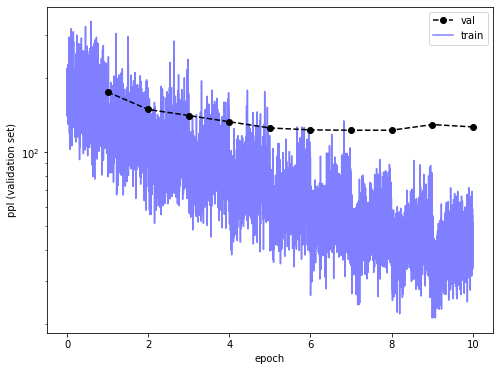

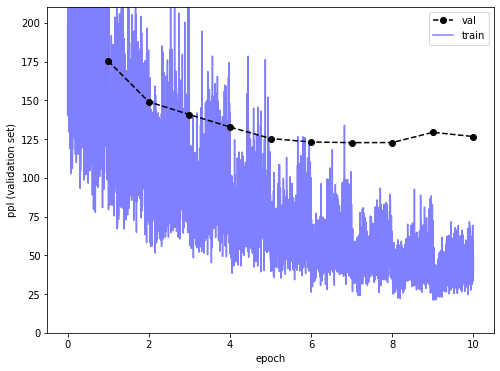

In [24]:
plot_training_timeseries(exp_name=dataset.name, logy=True)
plot_training_timeseries(exp_name=dataset.name, fname='training_performance_linear', logy=False, ylims=(0, np.max(training_ppl_val_coarse) * 1.2))

### Text Generation

Here I've simply taken the code Matt uses to generate text.

In [25]:
if not TRAIN:
    custom_filename = 'arxiv_10000'
    custom_epochs = 10
    model_full = settings.DIR_MODELS + os.sep + f'{custom_filename}_epoch_{custom_epochs}_best.pth'
    model_weights = settings.DIR_MODELS + os.sep + f'{custom_filename}_weights_epoch_{custom_epochs}_best.pth'
    
    # approach 1: load model (class) entirely (uses pickle)
    model_full_load = torch.load(model_full, map_location=device)

    # approach 2: load model weights, need to have some parameter or something 
    model_load = TransformerModel(vocab_size, emsize, nhead, nhid, nlayers, dropout).to(device)
    model_weights_load = model_load.load_state_dict( torch.load(model_weights) )

In [26]:
# inspect both models
#print('model_A info...\n', model_full_load)
#print('\nmodel_B info...\n', model_weights_load)

#print('model_A == model_B:', model_full_load == model_weights_load)
#model = model_full_load
# Text generation example

#model = model_load
prompt = 'The dog ran'
ngen = 100
decode_style = 'sample_topp' #greedy, sample_topp
model.to('cpu')
generated_text = gen_some_text(
    best_model, dataset.transform, 'cpu', max_len_sentence, text_prompt=prompt, tokens_to_gen=ngen, vis=False,
    decode_style=decode_style)
print("Text prompt:\n", prompt)
print("Number of tokens to generate:", ngen)
print("Generated_text:\n", generated_text)

# TODO: alternative generation
# currently 'greedy method'
# see: https://huggingface.co/blog/how-to-generate

TypeError: ignored